In [1]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('AMAZON_FASHION.json', lines=True)

In [4]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [6]:
review = review.dropna(subset=["reviewText"])

In [7]:
review = review.dropna(subset=["summary"])

In [8]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


### Data Preprocessing

In [64]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

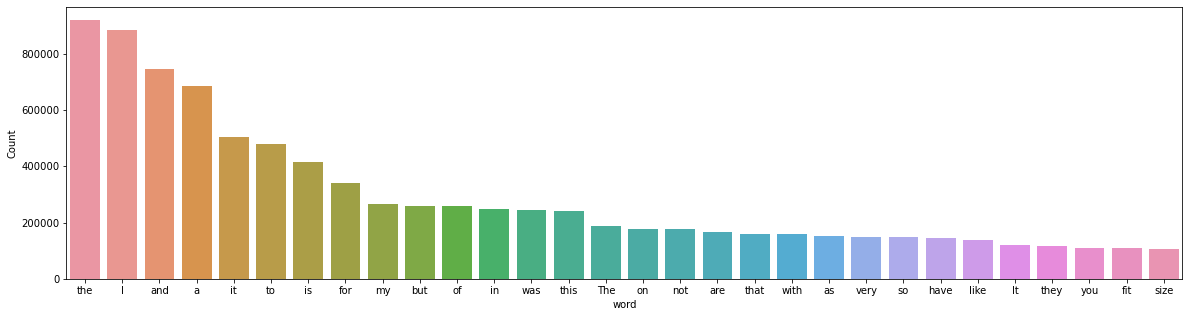

In [65]:
freq_words(review['reviewText'])

In [66]:
df = review['reviewText'].to_frame()
#df[['reviewText']]

In [12]:
#remove stop words as evidenced from previous diagram

In [67]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [68]:
stop = set(stopwords.words('english'))

In [69]:
stop.remove('not')

##choose to remove not since it may impact the sentiment and bigram analysis

In [70]:
df['noStopword'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

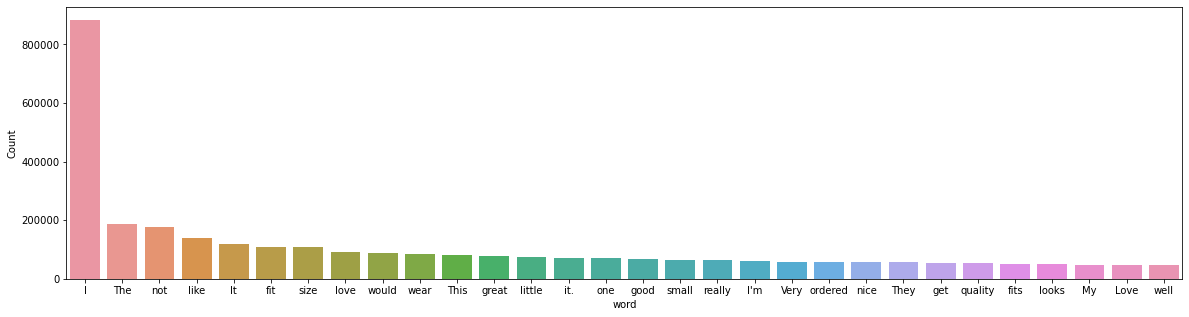

In [71]:
freq_words(df['noStopword'])

In [72]:
df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")
df['noStopword'] = df['noStopword'].str.lower()

/var/folders/51/42w_kz156q920kx3w9jz1lwm0000gn/T/ipykernel_22039/1549145191.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")


In [73]:
df['tokenized'] = df['noStopword'].apply(nltk.word_tokenize)

In [74]:
df['tagged'] = df['tokenized'].apply(nltk.pos_tag)

In [75]:
df['nouns'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [76]:
df['verbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])

In [77]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs
0,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re not seen would not buy price not sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, not, seen, would, not, buy, price, not, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]"
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[]
4,Okay,okay,[okay],"[(okay, NN)]",[okay],[]


In [78]:
df['Token_Count'] = df['tokenized'].str.len()

In [79]:
def norm_lemm_v_a_func(text):
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

In [80]:
df['lemmatized'] = df['noStopword'].apply(norm_lemm_v_a_func)

In [100]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs,Token_Count,lemmatized,clean,rating,sentiment
0,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],3,exactly i need,exactly need,5,positive
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re not seen would not buy price not sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, not, seen, would, not, buy, price, not, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]",26,i agree review open small i almost bend hook expensive earrings try get high end they re not see would not buy price not send back,agree review open small almost bend hook expensive earrings try get high end they not see would not buy price not send back,2,negative
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],2,tiny open,tiny open,2,negative
4,Okay,okay,[okay],"[(okay, NN)]",[okay],[],1,okay,okay,3,neutral


### EDA

In [82]:
def remove_single_char_func(text, threshold=1):
    threshold = threshold
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

In [83]:
df['clean'] = df['lemmatized'].apply(remove_single_char_func)
df['clean'] = df.apply(lambda x: remove_single_char_func(x["lemmatized"], threshold=2), axis = 1)

In [101]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs,Token_Count,lemmatized,clean,rating,sentiment
0,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],3,exactly i need,exactly need,5,positive
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re not seen would not buy price not sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, not, seen, would, not, buy, price, not, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]",26,i agree review open small i almost bend hook expensive earrings try get high end they re not see would not buy price not send back,agree review open small almost bend hook expensive earrings try get high end they not see would not buy price not send back,2,negative
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]",27,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],2,tiny open,tiny open,2,negative
4,Okay,okay,[okay],"[(okay, NN)]",[okay],[],1,okay,okay,3,neutral


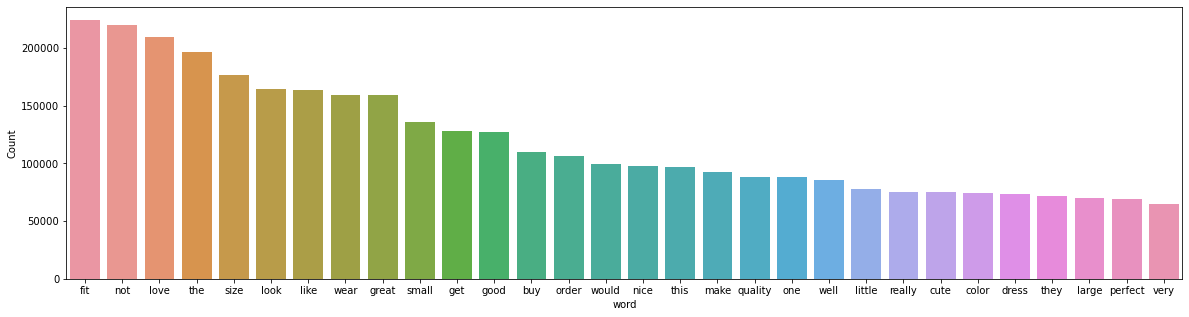

In [85]:
freq_words(df['clean'])

In [86]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

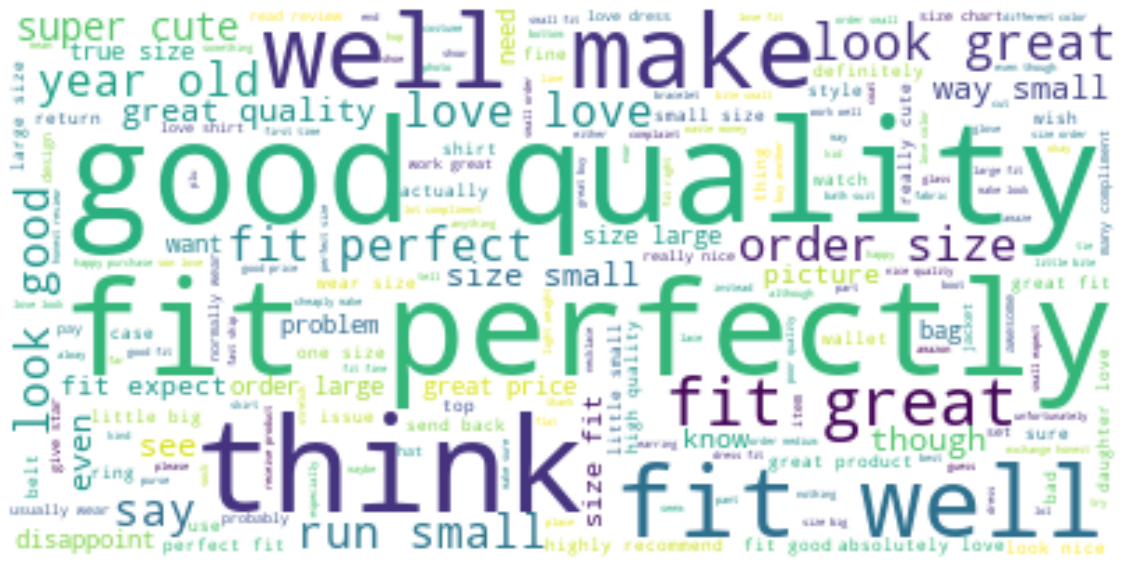

In [87]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [88]:
from nltk.collocations import *
from nltk.util import ngrams

In [89]:
word_list = ' '.join([i for i in df['clean']]).split()

In [90]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(look, like)        23860
(good, quality)     21112
(fit, perfectly)    18435
(well, make)        17670
(fit, well)         16520
(fit, great)        15659
(look, great)       15488
(order, size)       13886
(like, picture)     13021
(love, them)        12975
(year, old)         12300
(run, small)        12033
(fit, perfect)      11551
(look, good)        10962
(really, like)      10892
(love, love)        10818
(super, cute)       10674
(great, quality)    10366
(the, material)     10351
(way, small)         9711
dtype: int64

In [91]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(look, like, picture)             4699
(love, love, love)                3264
(get, lot, compliment)            3115
(get, pay, for)                   2970
(get, many, compliment)           2772
(receive, product, discount)      2522
(nothing, like, picture)          2441
(honest, unbiased, review)        2305
(would, not, recommend)           2235
(order, size, large)              2166
(look, nothing, like)             2100
(exchange, honest, review)        2019
(fit, true, size)                 1870
(exchange, honest, unbiased)      1866
(discount, exchange, honest)      1865
(would, definitely, recommend)    1848
(would, buy, again)               1808
(look, exactly, like)             1790
(one, size, fit)                  1745
(run, little, small)              1734
dtype: int64

In [92]:
search_word = ["love", "like", "hate", "great", "nice", 'the']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [93]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(good, quality)        21264
(fit, perfectly)       18439
(well, make)           17674
(fit, well)            16609
(order, size)          13957
(year, old)            12300
(run, small)           12043
(fit, perfect)         11720
(look, good)           11377
(super, cute)          10676
(way, small)            9716
(size, small)           9384
(size, fit)             8665
(fit, expect)           8621
(true, size)            8022
(order, large)          7970
(size, large)           7877
(think, would)          7677
(highly, recommend)     7597
(would, not)            7390
dtype: int64

In [94]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(get, lot, compliment)            3123
(get, pay, for)                   2970
(get, many, compliment)           2787
(receive, product, discount)      2530
(honest, unbiased, review)        2305
(would, not, recommend)           2235
(order, size, large)              2176
(exchange, honest, review)        2019
(fit, true, size)                 1929
(exchange, honest, unbiased)      1866
(discount, exchange, honest)      1865
(would, definitely, recommend)    1848
(would, buy, again)               1813
(one, size, fit)                  1760
(look, exactly, picture)          1737
(run, little, small)              1734
(receive, many, compliment)       1669
(year, old, daughter)             1656
(can, wait, wear)                 1538
(exactly, look, for)              1516
dtype: int64

## Sentiment Analysis

In [95]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [96]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [97]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [104]:
negative_review

,clean
1,agree review open small almost bend hook expensive earrings try get high end they not see would not buy price not send back
3,tiny open
11,smoke not make them get cigarettes close disappoint
12,cheap cheesy guess could expect price purchase another without see first
13,order ladies cigarette case wife pack marlboro would not fit case rip off cigarette case able hold cigarette pack not business silverhooks again not even worth postage send back dissatisfy big time
...,...
883602,size run time small label
883606,adorable seriously size soooooo far off juniors
883609,love pattern fabric bite sheer size small wear
883610,beautiful dress but run small normal size dress and top order large per size recommendations would barley wrap and top basically gap open expose half bra even wear camp would look like ill fit dre...


In [43]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [44]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [45]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [46]:
def most_common_word_func(text, n_words=25):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    df_fdist = pd.DataFrame({'Word': fdist.keys(),'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [47]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

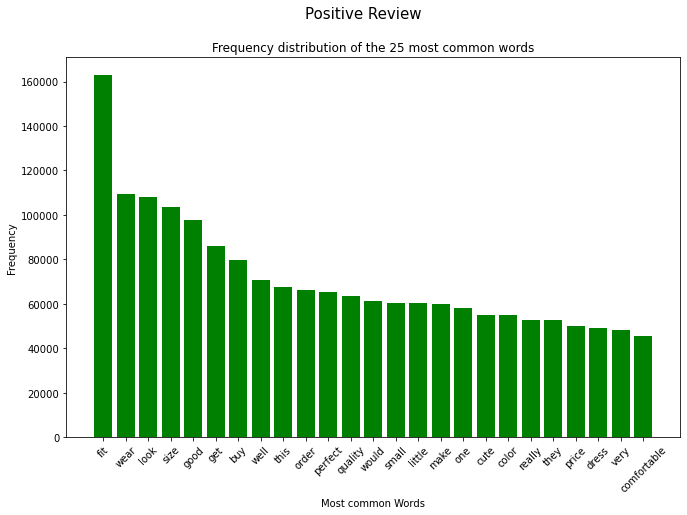

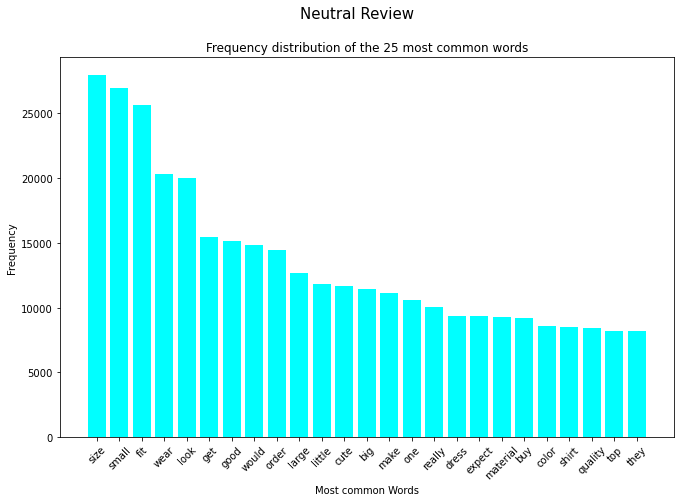

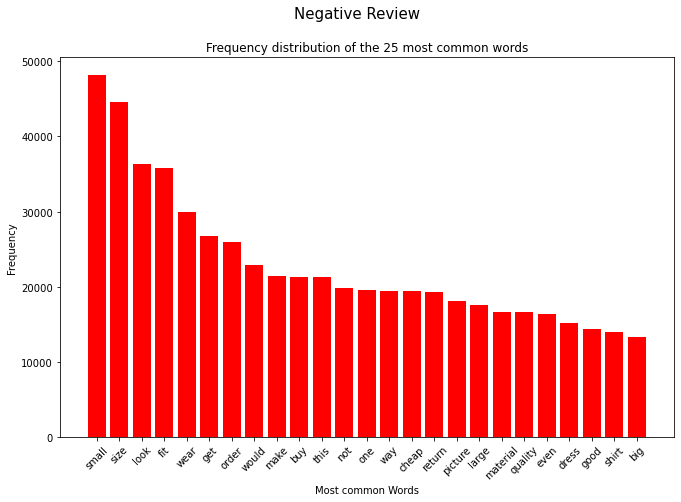

In [99]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'cyan', 'red']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']


for item in range(3):
    plt.figure(figsize=(11,7))
    plt.bar(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xticks(rotation = 45)
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

## Topic Modeling

In [50]:
doc_term_matrix = [dictionary.doc2bow(word) for word in df['tokenized']]

In [51]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [52]:
##lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)

print(lda_model.print_topics(num_topics=2, num_words=5))

[(2, '0.052*"it" + 0.042*"my" + 0.025*"daughter" + 0.025*"loved" + 0.023*"loves"'), (6, '0.164*"love" + 0.085*"it" + 0.068*"i" + 0.029*"bag" + 0.029*"perfect"')]
